In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import h5py
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

D0819 20:18:53.966854251      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0819 20:18:53.966878996      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0819 20:18:53.966892042      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0819 20:18:53.966895396      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0819 20:18:53.966898541      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0819 20:18:53.966901763      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0819 20:18:53.966904767      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0819 20:18:53.

In [3]:
with h5py.File('/kaggle/input/bit-vehicle/bitvehicle_dataset.h5', 'r') as file:
    images = file['images'][:]
    labels = file['labels'][:]

In [4]:
print('Total number of images: ',len(images))
print('Total number of labels: ',len(labels))

Total number of images:  9850
Total number of labels:  9850


In [5]:
unique_classes, class_counts = np.unique(labels, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class b'Bus': 555 samples
Class b'Microbus': 860 samples
Class b'Minivan': 467 samples
Class b'SUV': 1372 samples
Class b'Sedan': 5776 samples
Class b'Truck': 820 samples


In [6]:
resized_images = [Image.fromarray(image).resize((224, 224)) for image in images]
resized_images = np.array([preprocess_input(np.array(image)) for image in resized_images])

In [7]:
def adjust_brightness(image, factor):
    image = image.astype(np.float32)
    augmented_image = image + factor
    augmented_image = np.clip(augmented_image, 0, 255)
    augmented_image = augmented_image.astype(np.uint8)
    return augmented_image

def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def zoom_image(image, zoom_factor):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, zoom_factor)
    return cv2.warpAffine(image, M, (cols, rows))

def shift_image(image, dx, dy):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, M, (cols, rows))

In [8]:
augmented_images = []
augmented_labels = []

for img, label in zip(resized_images, labels):
    if label == b'Bus':
        augmented_img_brightness = adjust_brightness(img, 50)
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_img_rotate = rotate_image(img, 30)
        augmented_img_zoom = zoom_image(img, 1.2)
        augmented_img_shift = shift_image(img, 20, 20)
        augmented_images.extend([
            augmented_img_brightness,
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
            augmented_img_rotate,
            augmented_img_zoom,
            augmented_img_shift,
        ])
        augmented_labels.extend([label] * 6)
    if label == b'Minivan':
        augmented_img_brightness = adjust_brightness(img, 50)
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_img_rotate = rotate_image(img, 30)
        augmented_img_zoom = zoom_image(img, 1.2)
        augmented_img_shift = shift_image(img, 20, 20)
        augmented_images.extend([
            augmented_img_brightness,
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
            augmented_img_rotate,
            augmented_img_zoom,
            augmented_img_shift,
        ])
        augmented_labels.extend([label] * 6)
        
    if label == b'Microbus':
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_images.extend([
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
        ])
        augmented_labels.extend([label] * 2)
    
    if label == b'SUV':
        augmented_img_rotate = rotate_image(img, 30)
        augmented_images.extend([
            augmented_img_rotate,
        ])
        augmented_labels.extend([label] * 1)
        
    if label == b'Truck':
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_img_rotate = rotate_image(img, 30)
        augmented_images.extend([
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
            augmented_img_rotate,
        ])
        augmented_labels.extend([label] * 3)

    else:
        augmented_images.append(img)
        augmented_labels.append(label)

In [9]:
print('Total number of augmented images: ',len(augmented_images))
print('Total number of augmented labels: ',len(augmented_labels))

Total number of augmented images:  20714
Total number of augmented labels:  20714


In [10]:
unique_classes_aug, class_counts_aug = np.unique(augmented_labels, return_counts=True)
for class_label, count in zip(unique_classes_aug, class_counts_aug):
    print(f"Class {class_label}: {count} samples")

Class b'Bus': 3885 samples
Class b'Microbus': 2580 samples
Class b'Minivan': 3269 samples
Class b'SUV': 2744 samples
Class b'Sedan': 5776 samples
Class b'Truck': 2460 samples


In [11]:
images = np.array(augmented_images)
num_classes = len(np.unique(augmented_labels))
print('Number of classes',num_classes)

Number of classes 6


In [12]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(augmented_labels)
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

In [ ]:
labels = to_categorical(encoded_labels, num_classes)
unique_labels_set = set(tuple(label) for label in labels)
for unique_label in unique_labels_list:
    print(unique_label)

In [14]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.layers[-1].output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
k = 3
epochs = 3
batch_size = 32
kf = KFold(n_splits=k, shuffle=True)

accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []

confusion_matrices = []
all_true_labels = []
all_pred_labels = []
model_history = []

for fold, (train_index, test_index) in enumerate(kf.split(images), 1):
    print("Fold:", fold)
    X_train_fold, X_test_fold = images[train_index], images[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]

    history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size)

    y_pred = model.predict(X_test_fold)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test_fold, axis=1)

    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    
    confusion_matrices.append(cm)
    accuracy_values.append(report['accuracy'])
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_score_values.append(report['weighted avg']['f1-score'])

    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred)
    model_history.append(history)
    
avg_accuracy = np.mean(accuracy_values)
avg_weighted_precision = np.mean(precision_values)
avg_weighted_recall = np.mean(recall_values)
avg_weighted_f1_score = np.mean(f1_score_values)

print('Average accuracy:', avg_accuracy)
print('Average weighted precision:', avg_weighted_precision)
print('Average weighted recall:', avg_weighted_recall)
print('Average weighted f1 score:', avg_weighted_f1_score)

Fold: 1
Epoch 1/3
432/432 [==============================] - 306s 704ms/step - loss: 1.6612 - accuracy: 0.5661
Epoch 2/3
432/432 [==============================] - 302s 699ms/step - loss: 0.6259 - accuracy: 0.7757
Epoch 3/3
216/216 [==============================] - 145s 670ms/step
Fold: 2
Epoch 1/3
432/432 [==============================] - 297s 687ms/step - loss: 0.3626 - accuracy: 0.8747
Epoch 2/3
432/432 [==============================] - 299s 692ms/step - loss: 0.3037 - accuracy: 0.8962
Epoch 3/3
216/216 [==============================] - 151s 698ms/step
Fold: 3
Epoch 1/3
432/432 [==============================] - 297s 687ms/step - loss: 0.2296 - accuracy: 0.9201
Epoch 2/3
432/432 [==============================] - 302s 700ms/step - loss: 0.2125 - accuracy: 0.9287
Epoch 3/3
216/216 [==============================] - 150s 694ms/step
Average accuracy: 0.9431789621830678
Average weighted precision: 0.9436929949778531
Average weighted recall: 0.9431789621830678
Average weighted f1 sco

In [16]:
all_pred_labels = np.array(all_pred_labels)
all_true_labels = np.array(all_true_labels)
n_classes = len(np.unique(all_true_labels))
all_true_labels_binarized = label_binarize(all_true_labels, classes=range(n_classes))
true = all_true_labels_binarized.ravel()
pred = all_pred_labels.ravel()

In [17]:
roc_values = pd.DataFrame({
    'True_Class': true,
    'Pred_Class': pred,
})

roc_values.to_csv('/kaggle/working/BITVehicle_VGG19_ROC.csv', index=False)

In [18]:
learning_curves = pd.DataFrame({
    'Precision': precision_values,
    'Recall': recall_values,
    'F1_score': f1_score_values,
})

learning_curves.to_csv('/kaggle/working/BITVehicle_VGG19_Learning.csv', index=False)

In [19]:
history_values = pd.DataFrame({
    'History': model_history
})

history_values.to_csv('/kaggle/working/BITVehicle_VGG19_History.csv', index=False)

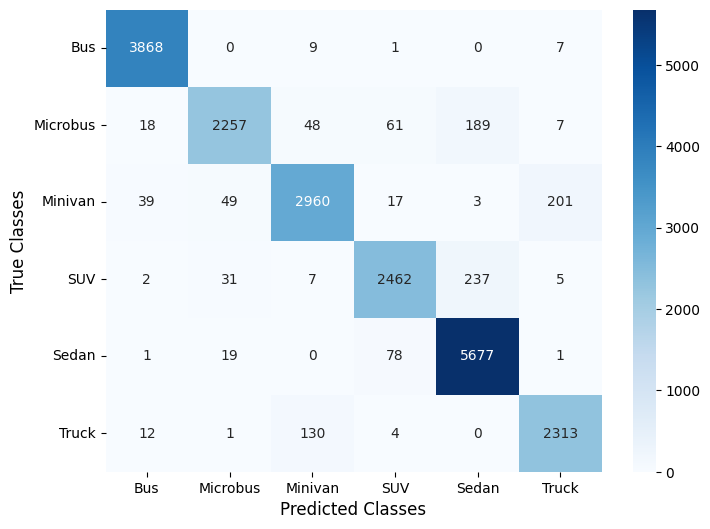

In [20]:
combined_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for fold, cm in enumerate(confusion_matrices, 1):
    combined_conf_matrix += cm

conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix1-BITVehicle_VGG19.png', dpi=300, bbox_inches='tight')
plt.show()

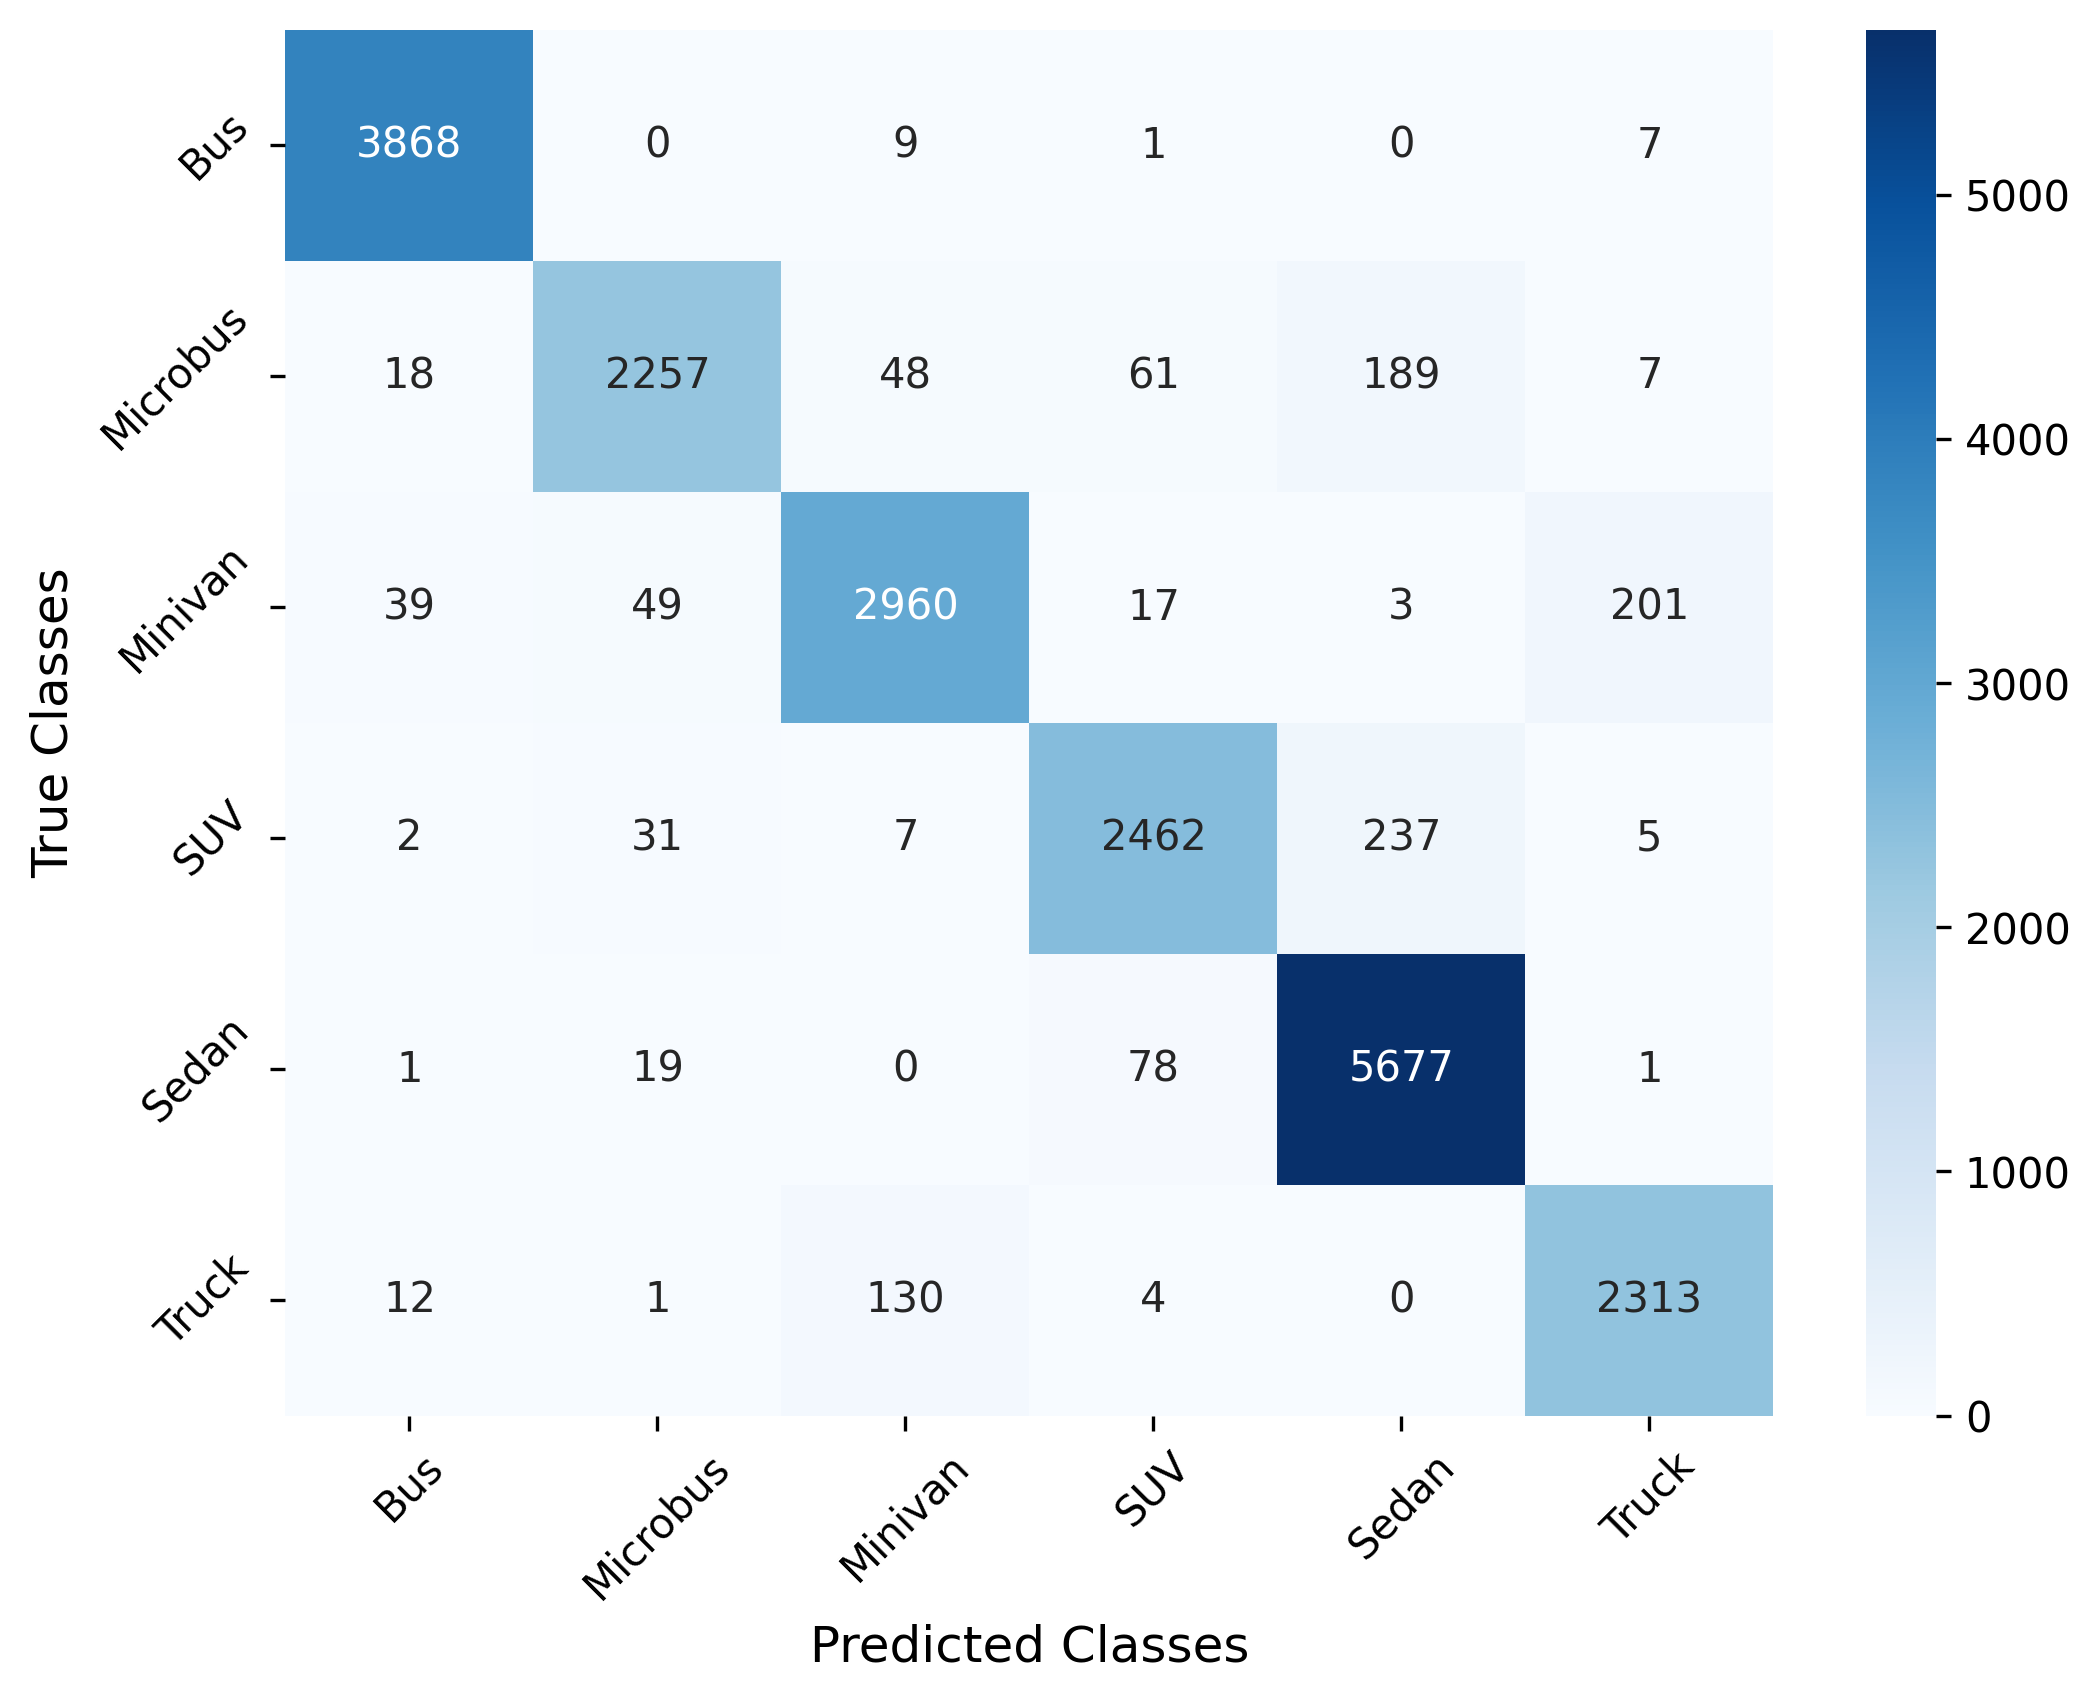

In [21]:
conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=45, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix2-BITVehicle_VGG19.png', dpi=300, bbox_inches='tight')
plt.show()